In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
from torch_geometric.nn import GCNConv

import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch_geometric.data import Data
import pandas as pd
from torch.utils.data import Dataset
from rdkit import Chem
from sklearn.metrics import roc_auc_score
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    GCNConv,
    global_mean_pool,
    global_add_pool
)
import matplotlib.pyplot as plt
import numpy as np
from rdkit.Chem import rdFingerprintGenerator
import deepchem as dc
import random
import optuna

import torch_geometric
import torch.optim as optim

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\predator\anaconda3\envs\dili\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


In [2]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Example

In [34]:
class ImageGraphDataset(Dataset):
    def __init__(self, image_dir, graph_data, transform=None):
        """
        Args:
            image_dir (str): Directory with all the images.
            graph_data (list of tuples): List of tuples where each tuple contains:
                                         (node_features, edge_index)
            transform (callable, optional): Optional transform to be applied
                                            on an image sample.
        """
        self.image_dir = image_dir
        self.graph_data = graph_data  # List of (node_features, edge_index)
        self.image_filenames = sorted(os.listdir(image_dir))  # List of image filenames
        self.transform = transform

    def __len__(self):
        # Return the minimum length of image files and graph data
        return min(len(self.image_filenames), len(self.graph_data))

    def __getitem__(self, idx):
        # Load the image
        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Load the corresponding graph data
        node_features, edge_index = self.graph_data[idx]

        # Convert graph data to tensors
        node_features = torch.tensor(node_features, dtype=torch.float)
        edge_index = torch.tensor(edge_index, dtype=torch.long)

        # Return image and graph data
        return image, node_features, edge_index

In [35]:
# Example graph data (replace with real data)
# List of (node_features, edge_index) for each graph
graph_data = [
    (torch.randn(32, 128), torch.randint(0, 32, (2, 64))),  # Example graph 1
    (torch.randn(32, 128), torch.randint(0, 32, (2, 64))),  # Example graph 2
    (torch.randn(32, 128), torch.randint(0, 32, (2, 64))),  # Example graph 3
    (torch.randn(32, 128), torch.randint(0, 32, (2, 64))),  # Example graph 4
]

# Image preprocessing (resize and convert to tensor)
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

# Initialize dataset
dataset = ImageGraphDataset(
    image_dir="data_smiles/Testing_Group/Hepatotoxicity",
    graph_data=graph_data,
    transform=transform,
)

# Initialize DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

/var/folders/y2/hzjfncr92llg100m08nwxmhc0000gn/T/ipykernel_61625/2239017323.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_features = torch.tensor(node_features, dtype=torch.float)
/var/folders/y2/hzjfncr92llg100m08nwxmhc0000gn/T/ipykernel_61625/2239017323.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge_index, dtype=torch.long)


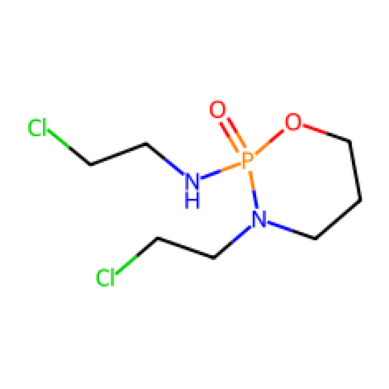

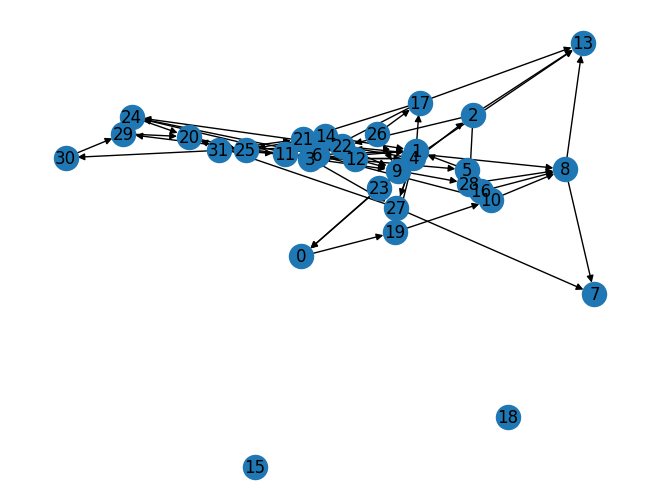

In [5]:
# plot the first image and graph data
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Get the first image and graph data
image, node_features, edge_index = dataset[0]

# Plot the image
plt.imshow(image.permute(1, 2, 0))
plt.axis("off")
plt.show()

# Plot the graph
G = to_networkx(Data(x=node_features, edge_index=edge_index))
nx.draw(G, with_labels=True)
plt.show()

# Data preparation

In [3]:
def featurize_smiles(smiles):
    featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
    graph_data = featurizer.featurize([smiles])[0]
    
    # Get DeepChem atom features
    atom_features_deepchem = graph_data.node_features
    
    return atom_features_deepchem

# Function to generate Morgan Fingerprints (ECFP)
def generate_ecfp(smiles):
    # Morgan fingerprint generator
    mfgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096)

    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:
        return None
    return mfgen.GetFingerprintAsNumPy(molecule)

# Function to convert SMILES to PyTorch Geometric Data object using DeepChem featurizer
def smiles_to_graph_featurizer(smiles):
    # Featurization using DeepChem
    featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)

    # Featurize the SMILES string using DeepChem
    graph_data = featurizer.featurize([smiles])[0]
    return graph_data.node_features, graph_data.edge_features, graph_data.edge_index

# Function to extract atom features
def atom_features(atom, ecfp):
    # Get the atom index for corresponding ECFP value
    atom_idx = atom.GetIdx()
    
    return  [
            atom.GetAtomicNum(),  # Atomic number
            atom.GetDegree(),  # Number of bonds
            atom.GetTotalNumHs(),  # Total number of hydrogens
            atom.GetFormalCharge(),  # Formal charge of the atom
            atom.GetImplicitValence(),  # Implicit valence
            atom.GetNumRadicalElectrons(),  # Number of radical electrons
            int(atom.GetIsAromatic()),  # Is the atom aromatic?
            atom.GetMass(),  # Atomic mass
            atom.GetHybridization().real,  # Hybridization state (SP, SP2, SP3, etc.)
            ecfp[atom_idx],  # Morgan fingerprint (ECFP) for the atom
        ]


# Function to extract bond features
def bond_features(bond):
    bond_type = bond.GetBondTypeAsDouble()            # Bond type as a float
    is_aromatic = bond.GetIsAromatic()                # Aromatic bond
    is_conjugated = bond.GetIsConjugated()            # Conjugated bond
    is_in_ring = bond.IsInRing()                      # Whether the bond is part of a ring
    stereo = bond.GetStereo()                         # Bond stereochemistry
    
    # Convert stereo information to a one-hot encoded format
    stereo_one_hot = [0, 0, 0, 0]  # Stereo options: None, E, Z, Other
    if stereo == Chem.BondStereo.STEREONONE:
        stereo_one_hot[0] = 1
    elif stereo == Chem.BondStereo.STEREOE:
        stereo_one_hot[1] = 1
    elif stereo == Chem.BondStereo.STEREOZ:
        stereo_one_hot[2] = 1
    else:
        stereo_one_hot[3] = 1
    
    # Combine all features into a single tensor
    return [bond_type, float(is_aromatic), float(is_conjugated), float(is_in_ring)] + stereo_one_hot


# Convert SMILES to PyTorch Geometric Data object
def smiles_to_graph(smiles, label):
    mol = Chem.MolFromSmiles(smiles)

    atom_features_list = []
    edge_index = []
    edge_attr = []

    # DeepChem features
    atom_features_deepchem = featurize_smiles(smiles)

    # Generate Morgan Fingerprint (ECFP)
    ecfp_features = generate_ecfp(smiles)

    # Generate Molecule Graph Convolution features
    mol_graph_node_features, mol_graph_edge_features, mol_graph_edge_index = smiles_to_graph_featurizer(smiles)

    # Nodes (atoms)
    for atom in mol.GetAtoms():
        atom_features_list.append(atom_features(atom, ecfp_features))

    atom_features_list = np.array(atom_features_list)

    # Edges (bonds)
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        
        # Append bidirectional edges for undirected graphs
        edge_index.append([i, j])
        edge_index.append([j, i])
        
        # Append bond features for both directions
        edge_attr.append(bond_features(bond))
        edge_attr.append(bond_features(bond))

    # Convert atom features to a tensor
    combined_features = np.concatenate((atom_features_list, atom_features_deepchem, mol_graph_node_features), axis=1)
    x = torch.tensor(combined_features, dtype=torch.float)

    # Convert edge indices and features to tensors, handle empty edge case    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # combine edge features from ECFP and MolGraphConv    
    edge_attr = np.array(edge_attr)
    edge_attr = np.concatenate((edge_attr, mol_graph_edge_features), axis=1)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    # Label (target)
    y = torch.tensor([label], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

In [4]:
class CSVImageGraphDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file.
            image_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image sample.
        """
        self.data = pd.read_csv(csv_file)  # Read the CSV
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load SMILES string and convert to graph
        item = self.data.iloc[idx]
        label = 1 if item["class_label"] == "Hepatotoxicity" else 0
        graph_data = smiles_to_graph(item["smiles"], label)

        # Load the corresponding image
        img_name = os.path.join(self.image_dir, item["filename"])
        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Load the label (hepatotoxicity in this case)        
        label = torch.tensor(label, dtype=torch.float)

        return image, graph_data, label

In [5]:
# Define image transformations for training and testing
train_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),  # Data augmentation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [6]:
# Initialize training dataset
training_dataset = CSVImageGraphDataset(
    csv_file="data_smiles/training_smiles_filename_mapping.csv",
    image_dir="data_smiles/Training_Group",
    transform=train_transforms,
)

# Initialize training DataLoader
train_loader = DataLoader(training_dataset, batch_size=64, shuffle=True)


In [7]:
# Initialize testing dataset
testing_dataset = CSVImageGraphDataset(
    csv_file="data_smiles/testing_smiles_filename_mapping.csv",
    image_dir="data_smiles/Testing_Group",
    transform=test_transforms,
)

# Initialize testing DataLoader
test_loader = DataLoader(testing_dataset, batch_size=64, shuffle=True)


In [45]:

# Example of loading a batch
for batch in test_loader:
    images, graph_data, label = batch
    print("Images:", images.shape)
    print("Graph data:", graph_data)
    print("Label:", label)

    break

Images: torch.Size([64, 3, 224, 224])
Graph data: DataBatch(x=[1696, 70], edge_index=[2, 3594], edge_attr=[3594, 19], y=[64], batch=[1696], ptr=[65])
Label: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 0.])


# Modeling

In [8]:
class ImageFeatureExtractor(nn.Module):
    def __init__(self):
        super(ImageFeatureExtractor, self).__init__()
        # Use ResNet18 for image feature extraction
        self.resnet = resnet18(pretrained=True)
        # Remove the final classification layer
        self.resnet.fc = nn.Identity()  # This will output features of size (batch_size, 224)

    def forward(self, x):
        # Forward pass through ResNet
        return self.resnet(x)  # Output shape: (batch_size, 224)

In [9]:
class GCNFeatureExtractor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNFeatureExtractor, self).__init__()
        # Two-layer GCN
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data_batch):
        # data_batch is a DataBatch object with node features `x` and edge_index
        x, edge_index = data_batch.x, data_batch.edge_index
        
        # First graph convolution + activation
        x = F.relu(self.conv1(x, edge_index))
        
        # Second graph convolution
        x = self.conv2(x, edge_index)
        
        # Mean-pooling over nodes in the same graph (for batched data)
        batch = data_batch.batch  # batch vector that assigns each node to a specific graph
        x = torch_geometric.nn.global_mean_pool(x, batch)  # shape: (batch_size, output_dim)

        return x  # shape: (batch_size, output_dim)


In [10]:
class CombinedModel(nn.Module):
    def __init__(self, gcn_input_dim, gcn_hidden_dim, gcn_output_dim, num_classes):
        super(CombinedModel, self).__init__()
        # Image feature extractor
        self.image_extractor = ImageFeatureExtractor()
        # GCN feature extractor
        self.gcn_extractor = GCNFeatureExtractor(gcn_input_dim, gcn_hidden_dim, gcn_output_dim)
        # Fully connected layer for combining features
        self.fc = nn.Linear(512 + gcn_output_dim, num_classes)  # Change 512 + 256 = 768
        
    def forward(self, images, graph_data):
        # Extract features from image
        image_features = self.image_extractor(images)  # shape: (batch_size, 512)
        
        # Extract features from graph
        graph_features = self.gcn_extractor(graph_data)  # shape: (batch_size, gcn_output_dim)
        
        # Combine both features (concatenation)
        combined_features = torch.cat([image_features, graph_features], dim=1)  # shape: (batch_size, 512 + gcn_output_dim)
        
        # Final classification
        output = self.fc(combined_features)  # Now the input to fc should have the correct size (batch_size, 768)
        return output


# Training

In [11]:
# Training function with AUC and accuracy tracking
def train(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    y_true = []
    y_pred = []

    for images, graph_data, labels in data_loader:
        images = images.to(device)  # Move image data to GPU
        graph_data = graph_data.to(device)  # Move graph data to GPU
        labels = labels.to(device).long()  # Cast labels to Long type for CrossEntropyLoss

        optimizer.zero_grad()
        # Forward pass through the model
        out = model(images, graph_data)
        
        # Calculate the loss
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        # Track metrics
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == labels).sum().item()
        y_true.extend(labels.cpu().tolist())  # Move labels back to CPU for metrics
        y_pred.extend(out[:, 1].detach().cpu().numpy())  # Probability for class 1

    acc = correct / len(data_loader.dataset)
    auc = roc_auc_score(y_true, y_pred)

    return total_loss / len(data_loader), acc, auc

In [12]:
# Evaluation function with AUC and accuracy tracking
def test(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, graph_data, labels in data_loader:
            images = images.to(device)  # Move image data to GPU
            graph_data = graph_data.to(device)  # Move graph data to GPU
            labels = labels.to(device).long()  # Cast labels to Long type for CrossEntropyLoss

            # Forward pass through the model
            out = model(images, graph_data)
            
            # Calculate the loss
            loss = criterion(out, labels)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == labels).sum().item()
            y_true.extend(labels.cpu().tolist())  # Move labels back to CPU for metrics
            y_pred.extend(out[:, 1].cpu().numpy())  # Probability for class 1

    acc = correct / len(data_loader.dataset)
    auc = roc_auc_score(y_true, y_pred)

    return total_loss / len(data_loader), acc, auc


In [51]:


# Initialize the model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CombinedModel(gcn_input_dim=70, gcn_hidden_dim=128, gcn_output_dim=256, num_classes=2).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Number of epochs
epochs = 1

# Training loop
for epoch in range(epochs):
    train_loss, train_acc, train_auc = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc, test_auc = test(model, test_loader, criterion, device)
    
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train AUC: {train_auc:.4f}')
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}')


c:\Users\predator\anaconda3\envs\dili\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\predator\anaconda3\envs\dili\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/1
Train Loss: 0.8127, Train Acc: 0.5463, Train AUC: 0.5291
Test Loss: 0.6114, Test Acc: 0.6783, Test AUC: 0.6447


# Tuning

In [13]:
# Objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    gcn_hidden_dim = trial.suggest_int('gcn_hidden_dim', 64, 256)
    gcn_output_dim = trial.suggest_int('gcn_output_dim', 128, 512)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    
    # Create the model using suggested hyperparameters
    model = CombinedModel(
        gcn_input_dim=70,  # Assuming node features dimension is 70
        gcn_hidden_dim=gcn_hidden_dim,
        gcn_output_dim=gcn_output_dim,
        num_classes=2
    ).to(device)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Metrics storage for plotting
    train_acc_history, train_loss_history, train_auc_history = [], [], []
    test_acc_history, test_loss_history, test_auc_history = [], [], []

    # Training loop for a few epochs
    best_auc = 0
    epoch_count = 0
    patience = 10
    max_epochs = 100
    for epoch in range(max_epochs):
        try:
            train_loss, train_acc, train_auc = train(model, train_loader, optimizer, criterion, device)
            
            # Evaluate the model on the test set
            test_loss, test_acc, test_auc = test(model, test_loader, criterion, device)

            # Store metrics for plotting
            epoch_count += 1
            train_acc_history.append(train_acc)
            train_loss_history.append(train_loss)
            train_auc_history.append(train_auc)
            test_acc_history.append(test_acc)
            test_loss_history.append(test_loss)
            test_auc_history.append(test_auc)

            if test_auc > best_auc:
                best_auc = test_auc
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= patience:
                break
        except Exception as e:
            print(f"Error in epoch {epoch}: {e}")
            break
    

    # Store the number of epochs in the trial's user attributes
    trial.set_user_attr("n_epochs", epoch_count)
    trial.set_user_attr("train_acc_history", train_acc_history)
    trial.set_user_attr("train_loss_history", train_loss_history)
    trial.set_user_attr("train_auc_history", train_auc_history)
    trial.set_user_attr("test_acc_history", test_acc_history)
    trial.set_user_attr("test_loss_history", test_loss_history)
    trial.set_user_attr("test_auc_history", test_auc_history)
    
    # Optuna will try to minimize the objective, so we return the negative AUC
    return test_auc  # Return AUC or accuracy depending on your focus


In [17]:
# Create the Optuna study
study = optuna.create_study(direction='maximize')  # We want to maximize AUC

# Optimize the study over multiple trials
study.optimize(objective, n_trials=50)  # Run 50 trials to find the best hyperparameters

[I 2024-10-22 21:46:25,621] A new study created in memory with name: no-name-27dc6e64-eaaf-4afb-bba2-af04e924cb21
c:\Users\predator\anaconda3\envs\dili\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\predator\anaconda3\envs\dili\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[I 2024-10-22 22:03:06,448] Trial 0 finished with value: 0.6863905325443785 and parameters: {'gcn_hidden_dim': 219, 'gcn_output_dim': 289, 'learning_rate': 0.0017057246388430891}. Best is trial 0 with value: 0.6863905325443785.
c:\

In [ ]:
print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [19]:
n_epochs = trial.user_attrs['n_epochs']
train_acc_history = trial.user_attrs['train_acc_history']
train_loss_history = trial.user_attrs['train_loss_history']
train_auc_history = trial.user_attrs['train_auc_history']
test_acc_history = trial.user_attrs['test_acc_history']
test_loss_history = trial.user_attrs['test_loss_history']
test_auc_history = trial.user_attrs['test_auc_history']


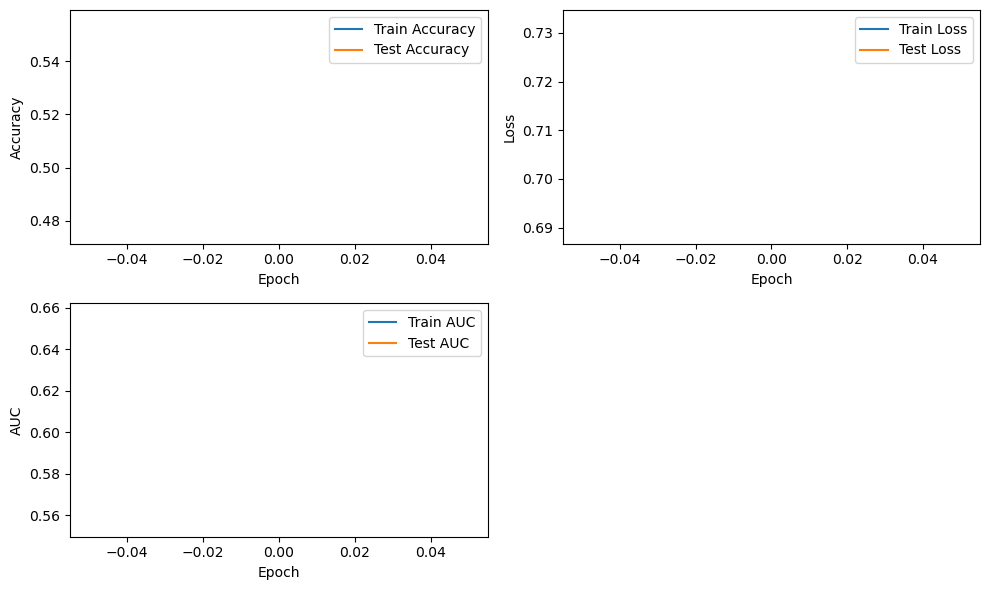

In [20]:
# Plot training and testing accuracy
epochs = len(train_acc_history)
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(range(epochs), train_acc_history, label="Train Accuracy")
plt.plot(range(epochs), test_acc_history, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(range(epochs), train_loss_history, label="Train Loss")
plt.plot(range(epochs), test_loss_history, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot AUC for train and test
plt.subplot(2, 2, 3)
plt.plot(range(epochs), train_auc_history, label="Train AUC")
plt.plot(range(epochs), test_auc_history, label="Test AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()

plt.tight_layout()
plt.show()